# Trying out constraints

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import IPython
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.shadow.common import (
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from tqdm import tqdm

%matplotlib inline

In [5]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

53759


In [6]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/optuna


In [9]:
root_dir = Path(aps.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'28-ID'
temp_work_dir = base_dir / f'tmp_work_dir_28-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [10]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [11]:
os.chdir(temp_work_dir)

In [12]:
input_beam_path = "primary_optics_system_beam.dat"

In [13]:
move_motors_ranges = {
    "hb_1": [-50, 50],
    "hb_2": [-50, 50],
    "hb_pitch": [-0.02, 0.02],  # in mrad
    "hb_trans": [-20, 20],  # in mrad
    "vb_bender": [-30, 30],
    "vb_pitch": [-0.02, 0.02],
    "vb_trans": [-30, 30],
}

In [25]:
xrange, yrange = configs.X_RANGE, configs.Y_RANGE

In [14]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


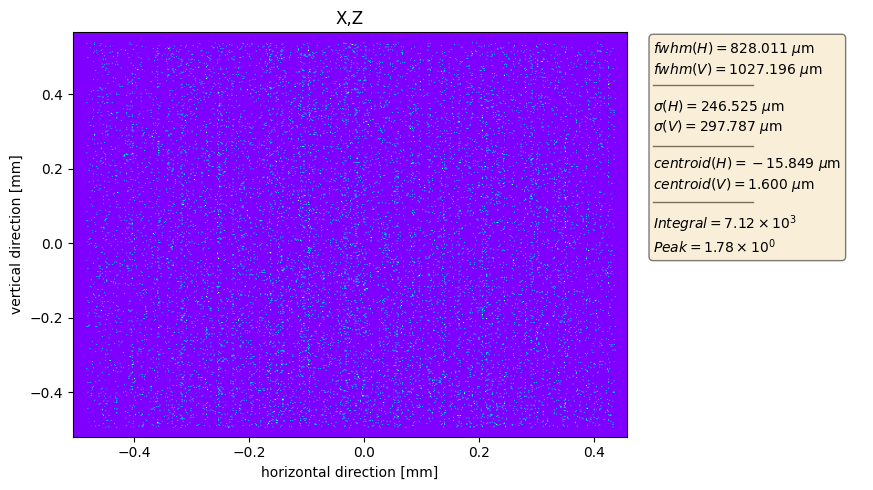

In [18]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    nbins=501,
)

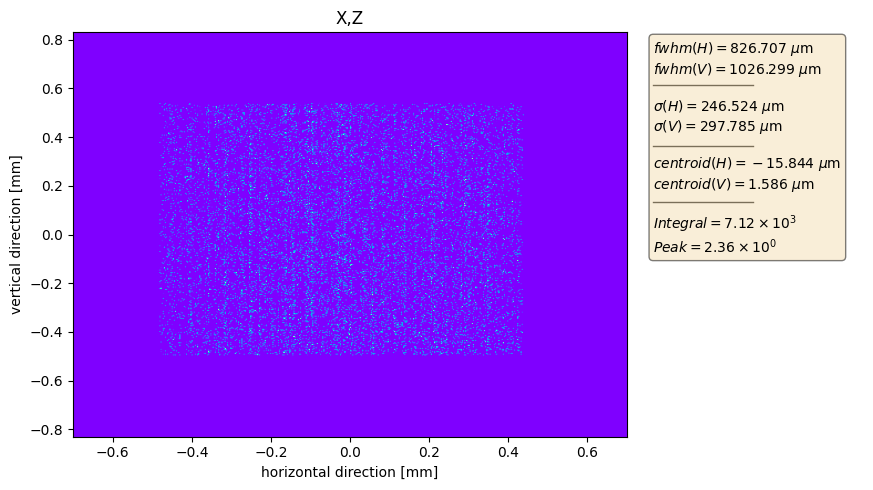

In [21]:
plot_shadow_beam_spatial_distribution(
    beam,
    nbins=501,
    xrange=configs.X_RANGE,
    yrange=configs.Y_RANGE
)

In [22]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[-90. -90.   3.   0. 170.   3.   0.]


In [24]:
centroid_ground, *_ = opt_common.get_centroid_distance(
    photon_beam=beam,
    xrange=configs.X_RANGE,
    yrange=configs.Y_RANGE,
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
sigma_ground, *_ = opt_common.get_sigma(
    photon_beam=beam,
    xrange=configs.X_RANGE,
    yrange=configs.Y_RANGE,
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
centroid_ground, sigma_ground

(0.015923155588438848, 0.38658757439089614)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [40.50136148998752, -18.639589934057753, 0.0036373613123723593, 3.18068963232486, 26.994229410730874, 0.012783374697576424, -28.978788349985432]


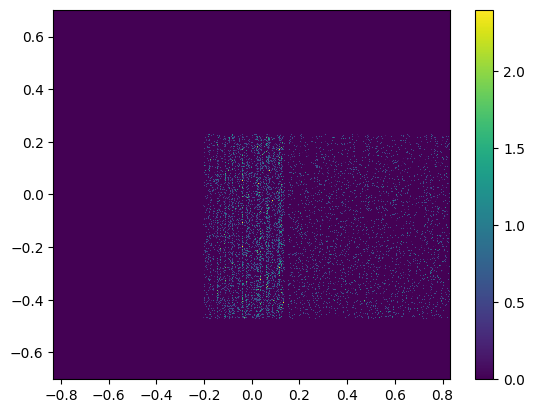

In [27]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=xrange,
    yrange=yrange,
    intensity_sum_threshold=1e3,
    nbins=501,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [28]:
hist.data_2D.sum()

6042.922497139866

In [103]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
0.09134704189962643 0.3748522565946506


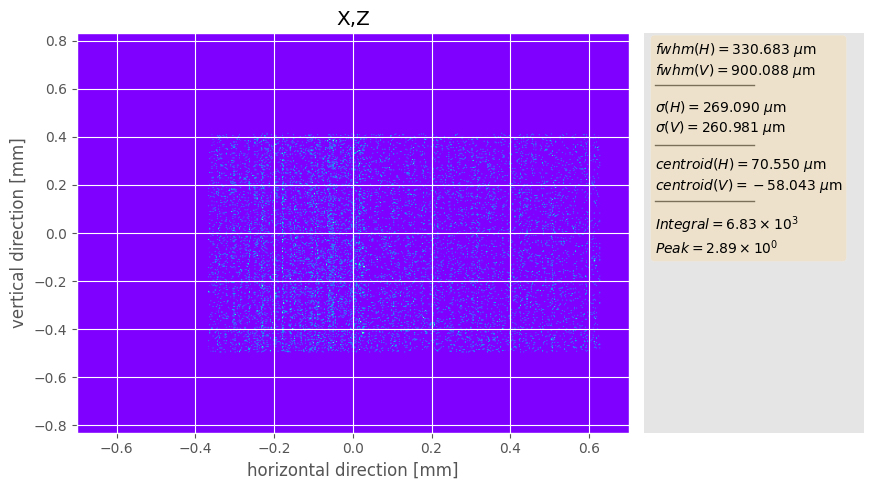

In [104]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=xrange,
    yrange=yrange,
    nbins=501,
)

In [105]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    random_seed=DEFAULT_RANDOM_SEED,
    loss_parameters=["centroid", "sigma"],
    use_gaussian_fit=False,
    multi_objective_optimization=True,
    camera_xrange=xrange,
    camera_yrange=yrange,
    camera_nbins=501,
)
# opt_trial.motor_ranges = centroid_ranges

In [106]:
constraints = {"sum_intensity": 6.5e3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=6e3,
    moo_thresholds={"centroid": 0.03, "sigma": 0.4},
    constraints=constraints,
)

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline28IDB/optimization/optuna_botorch.py:300: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler(
[I 2022-11-07 15:37:55,254] A new study created in memory with name: no-name-ab3d9bd1-9f84-4362-bf29-022d40037139


In [107]:
opt_trial.trials(50)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:57,764] Trial 1 finished with values: [0.10126043558957049, 0.3184950925878487] and parameters: {'hb_1': -33.0, 'hb_2': -38.0, 'hb_pitch': -0.01475, 'hb_trans': 6.100000000000001, 'vb_bender': 10.0, 'vb_pitch': 0.0045000000000000005, 'vb_trans': 20.700000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:58,061] Trial 2 finished with values: [0.050300889581681496, 0.4296459045904053] and parameters: {'hb_1': 30.0, 'hb_2': 27.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': -0.8999999999999986, 'vb_bender': -6.0, 'vb_pitch': -0.0165, 'vb_trans': 5.100000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:58,354] Trial 3 finished with values: [0.20425456116633983, 0.3408173274027454] and parameters: {'hb_1': 13.0, 'hb_2': 0.0, 'hb_pitch': 0.015000000000000003, 'hb_trans': 6.400000000000002, 'vb_bender': 25.0, 'vb_pitch': 0.006249999999999999, 'vb_trans': -18.2}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:58,689] Trial 4 finished with values: [0.11642221996470742, 0.44079620050234575] and parameters: {'hb_1': 47.0, 'hb_2': 37.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 7.800000000000001, 'vb_bender': 6.0, 'vb_pitch': 0.008, 'vb_trans': -1.0999999999999979}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:58,986] Trial 5 finished with values: [0.13260857379260774, 0.37013323702996914] and parameters: {'hb_1': -3.0, 'hb_2': -37.0, 'hb_pitch': -0.0165, 'hb_trans': -3.0, 'vb_bender': -21.0, 'vb_pitch': 0.0115, 'vb_trans': 16.800000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:59,285] Trial 6 finished with values: [0.049511995817038676, 0.3082342608248346] and parameters: {'hb_1': -45.0, 'hb_2': -20.0, 'hb_pitch': -0.0007500000000000007, 'hb_trans': 3.900000000000002, 'vb_bender': 10.0, 'vb_pitch': -0.01125, 'vb_trans': -13.3}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:59,581] Trial 7 finished with values: [0.21014103152373878, 0.39580900466734287] and parameters: {'hb_1': -24.0, 'hb_2': 45.0, 'hb_pitch': 0.015000000000000003, 'hb_trans': 16.4, 'vb_bender': 1.0, 'vb_pitch': 0.016749999999999998, 'vb_trans': 26.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:37:59,878] Trial 8 pruned. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:00,178] Trial 9 finished with values: [0.05880999078785273, 0.41269258687541466] and parameters: {'hb_1': 28.0, 'hb_2': 33.0, 'hb_pitch': -0.0024999999999999988, 'hb_trans': 15.100000000000001, 'vb_bender': 13.0, 'vb_pitch': -0.01825, 'vb_trans': 3.8999999999999986}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:00,472] Trial 10 finished with values: [0.08939467719262816, 0.364731138394692] and parameters: {'hb_1': -24.0, 'hb_2': 26.0, 'hb_pitch': 0.008, 'hb_trans': 14.600000000000001, 'vb_bender': 16.0, 'vb_pitch': -0.01825, 'vb_trans': 28.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:04,733] Trial 11 finished with values: [0.02764940007608239, 0.32876251201445283] and parameters: {'hb_1': -32.0, 'hb_2': -13.0, 'hb_pitch': -0.006, 'hb_trans': 4.900000000000002, 'vb_bender': 8.0, 'vb_pitch': -0.01475, 'vb_trans': -1.6999999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:10,426] Trial 12 finished with values: [0.07882416920867102, 0.3273236746600882] and parameters: {'hb_1': -33.0, 'hb_2': -13.0, 'hb_pitch': -0.0007500000000000007, 'hb_trans': 4.300000000000001, 'vb_bender': 6.0, 'vb_pitch': -0.02, 'vb_trans': -7.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:15,802] Trial 13 finished with values: [0.01818083038568174, 0.31904087754865973] and parameters: {'hb_1': -37.0, 'hb_2': -19.0, 'hb_pitch': -0.0095, 'hb_trans': 4.700000000000003, 'vb_bender': 10.0, 'vb_pitch': -0.0095, 'vb_trans': -1.7999999999999972}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:24,354] Trial 14 finished with values: [0.006210344773720038, 0.31729369523842155] and parameters: {'hb_1': -41.0, 'hb_2': -16.0, 'hb_pitch': -0.006, 'hb_trans': 3.1000000000000014, 'vb_bender': 16.0, 'vb_pitch': -0.01125, 'vb_trans': 4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:30,700] Trial 15 finished with values: [0.015790178908844238, 0.3084585301421775] and parameters: {'hb_1': -42.0, 'hb_2': -28.0, 'hb_pitch': -0.006, 'hb_trans': 6.600000000000001, 'vb_bender': 15.0, 'vb_pitch': -0.01125, 'vb_trans': 7.600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:37,233] Trial 16 finished with values: [0.013964449941367396, 0.31772399646814925] and parameters: {'hb_1': -28.0, 'hb_2': -25.0, 'hb_pitch': -0.00775, 'hb_trans': 1.6000000000000014, 'vb_bender': 20.0, 'vb_pitch': -0.01125, 'vb_trans': 4.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:42,857] Trial 17 finished with values: [0.01263871917088561, 0.32374873874681254] and parameters: {'hb_1': -34.0, 'hb_2': -9.0, 'hb_pitch': -0.00775, 'hb_trans': 6.800000000000001, 'vb_bender': 20.0, 'vb_pitch': -0.01125, 'vb_trans': 6.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:48,149] Trial 18 finished with values: [0.006012693381033736, 0.3314759546540458] and parameters: {'hb_1': -35.0, 'hb_2': -13.0, 'hb_pitch': -0.00775, 'hb_trans': 0.9000000000000021, 'vb_bender': 12.0, 'vb_pitch': -0.01125, 'vb_trans': 11.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:52,704] Trial 19 finished with values: [0.027728471168485327, 0.3099231031510186] and parameters: {'hb_1': -50.0, 'hb_2': -18.0, 'hb_pitch': -0.0095, 'hb_trans': 0.8000000000000007, 'vb_bender': 18.0, 'vb_pitch': -0.01125, 'vb_trans': 7.100000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:38:59,187] Trial 20 finished with values: [0.015430608106824492, 0.3323638265613173] and parameters: {'hb_1': -29.0, 'hb_2': -13.0, 'hb_pitch': -0.006, 'hb_trans': 3.0, 'vb_bender': 13.0, 'vb_pitch': -0.0095, 'vb_trans': 7.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:39:04,306] Trial 21 finished with values: [0.01360595777858351, 0.32320844672731275] and parameters: {'hb_1': -33.0, 'hb_2': -20.0, 'hb_pitch': -0.00775, 'hb_trans': 4.100000000000001, 'vb_bender': 15.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 10.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:39:11,557] Trial 22 finished with values: [0.00530770909616591, 0.3297687100764999] and parameters: {'hb_1': -35.0, 'hb_2': -8.0, 'hb_pitch': -0.006, 'hb_trans': -1.3000000000000007, 'vb_bender': 17.0, 'vb_pitch': -0.01125, 'vb_trans': 5.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:39:19,636] Trial 23 finished with values: [0.004728756451117711, 0.3239606564197049] and parameters: {'hb_1': -37.0, 'hb_2': -15.0, 'hb_pitch': -0.00775, 'hb_trans': -0.1999999999999993, 'vb_bender': 15.0, 'vb_pitch': -0.01125, 'vb_trans': 5.700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:39:24,534] Trial 24 finished with values: [0.024084741817300456, 0.3010037792445882] and parameters: {'hb_1': -41.0, 'hb_2': -30.0, 'hb_pitch': -0.006, 'hb_trans': 1.9000000000000021, 'vb_bender': 23.0, 'vb_pitch': -0.0095, 'vb_trans': 1.6000000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warn

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:39:42,710] Trial 25 finished with values: [0.0037432354421758156, 0.3294218143779813] and parameters: {'hb_1': -38.0, 'hb_2': -9.0, 'hb_pitch': -0.006, 'hb_trans': 0.8000000000000007, 'vb_bender': 13.0, 'vb_pitch': -0.01125, 'vb_trans': 6.600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:39:50,562] Trial 26 finished with values: [0.012522114904358193, 0.3252169398216487] and parameters: {'hb_1': -38.0, 'hb_2': -17.0, 'hb_pitch': -0.006, 'hb_trans': -2.3000000000000007, 'vb_bender': 13.0, 'vb_pitch': -0.01125, 'vb_trans': 8.300000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:00,527] Trial 27 finished with values: [0.01643281543741419, 0.3321583171823128] and parameters: {'hb_1': -36.0, 'hb_2': -4.0, 'hb_pitch': -0.00775, 'hb_trans': 1.3000000000000007, 'vb_bender': 15.0, 'vb_pitch': -0.01125, 'vb_trans': 5.100000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:07,807] Trial 28 finished with values: [0.02033920274108384, 0.3207593859401227] and parameters: {'hb_1': -38.0, 'hb_2': -13.0, 'hb_pitch': -0.00425, 'hb_trans': 2.0, 'vb_bender': 22.0, 'vb_pitch': -0.01125, 'vb_trans': 10.800000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:13,043] Trial 29 finished with values: [0.01729949040602148, 0.3043170043874776] and parameters: {'hb_1': -41.0, 'hb_2': -27.0, 'hb_pitch': -0.006, 'hb_trans': 4.400000000000002, 'vb_bender': 19.0, 'vb_pitch': -0.01125, 'vb_trans': 0.10000000000000142}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:17,200] Trial 30 finished with values: [0.015714724944512908, 0.3455968296384608] and parameters: {'hb_1': -20.0, 'hb_2': -10.0, 'hb_pitch': -0.00775, 'hb_trans': -6.0, 'vb_bender': 13.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 8.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:20,652] Trial 31 finished with values: [0.008053238272348884, 0.3319570066894704] and parameters: {'hb_1': -19.0, 'hb_2': -9.0, 'hb_pitch': -0.00775, 'hb_trans': -6.799999999999999, 'vb_bender': 25.0, 'vb_pitch': -0.01125, 'vb_trans': -9.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:27,089] Trial 32 finished with values: [0.004924361703506052, 0.3282305508361122] and parameters: {'hb_1': -29.0, 'hb_2': -13.0, 'hb_pitch': -0.00775, 'hb_trans': -6.0, 'vb_bender': 16.0, 'vb_pitch': -0.01125, 'vb_trans': -6.299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:31,865] Trial 33 finished with values: [0.002156234706077646, 0.31253857026928283] and parameters: {'hb_1': -35.0, 'hb_2': -15.0, 'hb_pitch': -0.00775, 'hb_trans': -1.5, 'vb_bender': 24.0, 'vb_pitch': -0.01125, 'vb_trans': -10.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:40:36,853] Trial 34 finished with values: [0.002029866704619838, 0.29360058979255144] and parameters: {'hb_1': -40.0, 'hb_2': -20.0, 'hb_pitch': -0.00775, 'hb_trans': 0.8000000000000007, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -25.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:41:04,036] Trial 35 finished with values: [0.009013565820088176, 0.2910246100239777] and parameters: {'hb_1': -46.0, 'hb_2': -20.0, 'hb_pitch': -0.00775, 'hb_trans': 3.400000000000002, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -16.6}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:41:17,503] Trial 36 finished with values: [0.009751716920474598, 0.30563749298603454] and parameters: {'hb_1': -37.0, 'hb_2': -14.0, 'hb_pitch': -0.006, 'hb_trans': -1.3000000000000007, 'vb_bender': 28.0, 'vb_pitch': -0.01125, 'vb_trans': -19.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of i

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:41:41,956] Trial 37 finished with values: [0.0073161056326052345, 0.30303499694229163] and parameters: {'hb_1': -31.0, 'hb_2': -20.0, 'hb_pitch': -0.0095, 'hb_trans': -1.0999999999999979, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -21.799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:42:15,582] Trial 38 finished with values: [0.0034639047591008814, 0.306376192956261] and parameters: {'hb_1': -37.0, 'hb_2': -17.0, 'hb_pitch': -0.00775, 'hb_trans': 0.8000000000000007, 'vb_bender': 22.0, 'vb_pitch': -0.01125, 'vb_trans': -19.7}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:42:30,936] Trial 39 finished with values: [0.009861236721403904, 0.2781744836497658] and parameters: {'hb_1': -46.0, 'hb_2': -31.0, 'hb_pitch': -0.00775, 'hb_trans': 11.3, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -19.9}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:43:06,255] Trial 40 finished with values: [0.011408963470446527, 0.29287985624535245] and parameters: {'hb_1': -36.0, 'hb_2': -23.0, 'hb_pitch': -0.00775, 'hb_trans': 0.7000000000000028, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:43:48,397] Trial 41 finished with values: [0.011544561498365538, 0.2665684486099155] and parameters: {'hb_1': -50.0, 'hb_2': -38.0, 'hb_pitch': -0.00775, 'hb_trans': 16.9, 'vb_bender': 30.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': -23.3}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:44:12,058] Trial 42 finished with values: [0.003656145799507196, 0.2829190530457121] and parameters: {'hb_1': -39.0, 'hb_2': -26.0, 'hb_pitch': -0.00775, 'hb_trans': 15.300000000000004, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -25.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:44:45,890] Trial 43 finished with values: [0.014242834074105946, 0.27443340734944816] and parameters: {'hb_1': -50.0, 'hb_2': -28.0, 'hb_pitch': -0.00775, 'hb_trans': 18.5, 'vb_bender': 24.0, 'vb_pitch': -0.01125, 'vb_trans': -30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial condit

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:45:27,158] Trial 44 finished with values: [0.012237683149726227, 0.28599995324389044] and parameters: {'hb_1': -36.0, 'hb_2': -28.0, 'hb_pitch': -0.00775, 'hb_trans': 10.100000000000001, 'vb_bender': 30.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': -25.4}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:45:32,745] Trial 45 finished with values: [0.01732731125149395, 0.265609857967244] and parameters: {'hb_1': -41.0, 'hb_2': -47.0, 'hb_pitch': -0.01125, 'hb_trans': 19.800000000000004, 'vb_bender': 29.0, 'vb_pitch': -0.0095, 'vb_trans': -26.4}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:45:44,727] Trial 46 finished with values: [0.01865540493102685, 0.2747247353450742] and parameters: {'hb_1': -45.0, 'hb_2': -30.0, 'hb_pitch': -0.0095, 'hb_trans': 14.800000000000004, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -28.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:46:19,798] Trial 47 finished with values: [0.016168655484696783, 0.2600368934020255] and parameters: {'hb_1': -46.0, 'hb_2': -50.0, 'hb_pitch': -0.00775, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -25.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:47:00,589] Trial 48 finished with values: [0.002077475393256988, 0.2808121324373826] and parameters: {'hb_1': -38.0, 'hb_2': -33.0, 'hb_pitch': -0.00775, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -14.399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:47:24,557] Trial 49 finished with values: [0.005820080354402249, 0.27751096964656] and parameters: {'hb_1': -46.0, 'hb_2': -30.0, 'hb_pitch': -0.006, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -13.099999999999998}. 


In [99]:
opt_trial.study.best_trials

[FrozenTrial(number=19, values=[0.0039748891667371715, 0.33437875934660555], datetime_start=datetime.datetime(2022, 11, 7, 15, 27, 5, 719269), datetime_complete=datetime.datetime(2022, 11, 7, 15, 27, 18, 44732), params={'hb_1': -15.0, 'hb_2': -14.0, 'hb_pitch': -0.0095, 'hb_trans': 3.400000000000002, 'vb_bender': 15.0, 'vb_pitch': -0.01125, 'vb_trans': -7.799999999999997}, distributions={'hb_1': FloatDistribution(high=50.0, log=False, low=-50.0, step=1.0), 'hb_2': FloatDistribution(high=50.0, log=False, low=-50.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'hb_trans': FloatDistribution(high=19.9, log=False, low=-20.0, step=0.1), 'vb_bender': FloatDistribution(high=30.0, log=False, low=-30.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'vb_trans': FloatDistribution(high=29.9, log=False, low=-30.0, step=0.1)}, user_attrs={'sum_intensity_constraint': -1, 'wsum': 1838.1880857664717}, system_attrs

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_5518/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


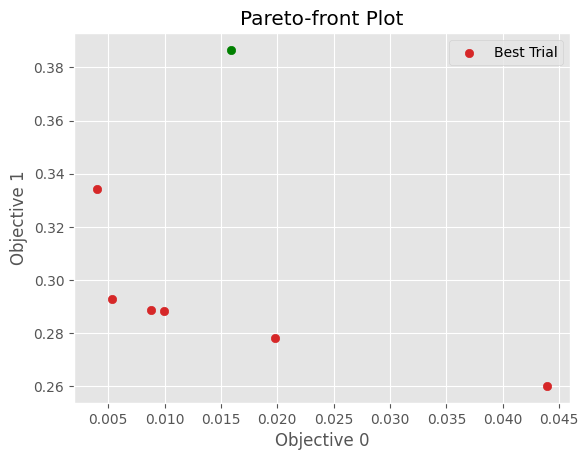

In [100]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [101]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-6.623239332335743 1838.1880857664717
-5.203049460611624 1739.337032732646
-6.462423602747777 1771.230921776231
-5.855054430331085 1797.2611820985694
-4.47092123496882 1644.6683556963026
-5.979138582625643 1756.7347679502066


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.0039748891667371715, 0.33437875934660555] 1838.1880857664717


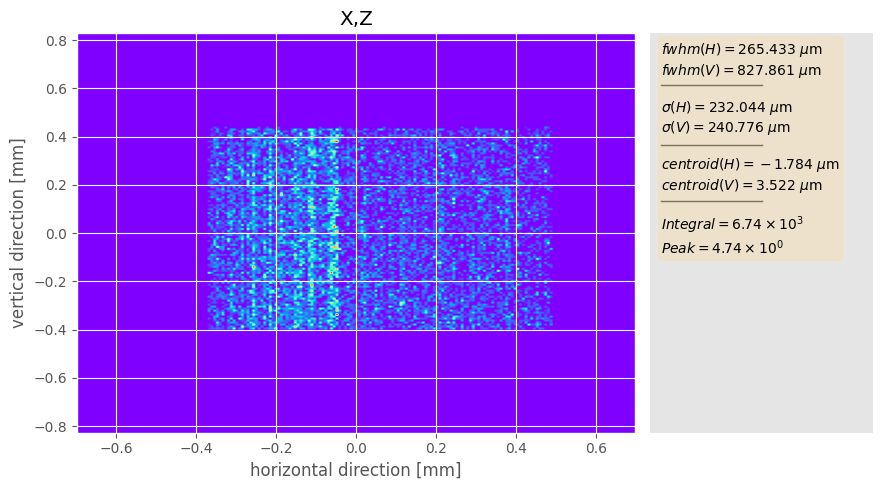

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.019763978839030406, 0.27827228228861495] 1739.337032732646


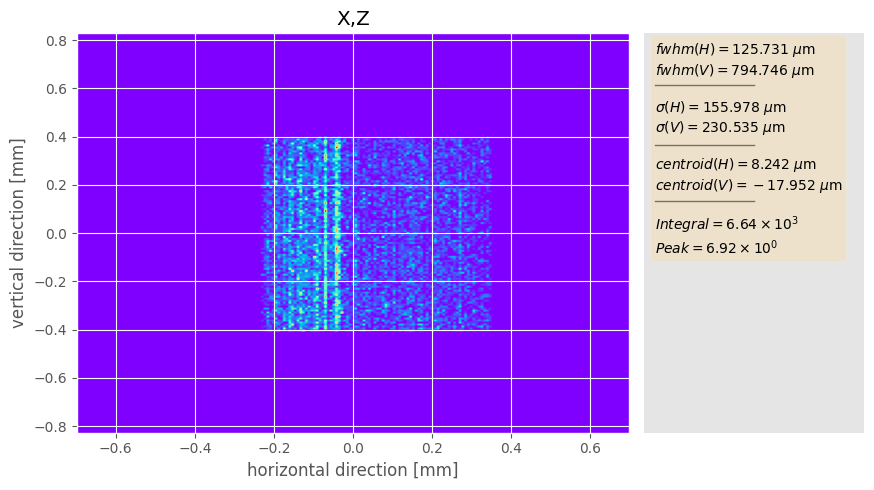

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.005328059415474603, 0.2929786883859474] 1771.230921776231


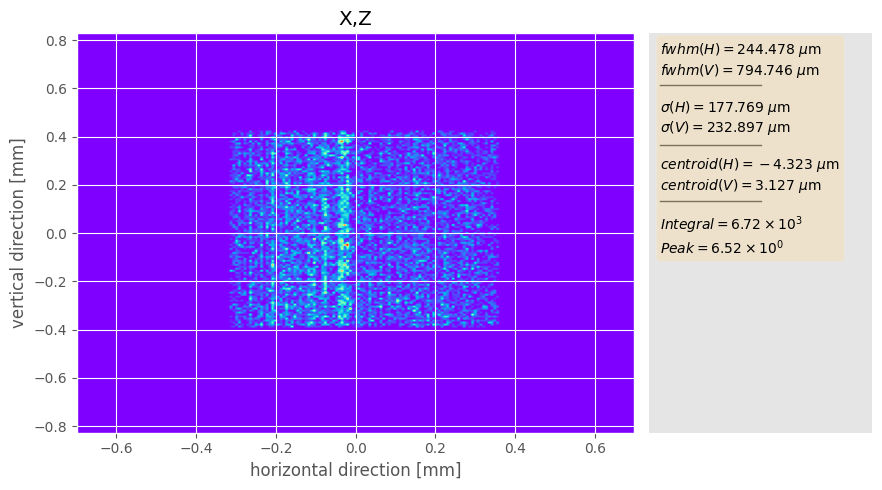

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.009932031688722639, 0.28849884123517544] 1797.2611820985694


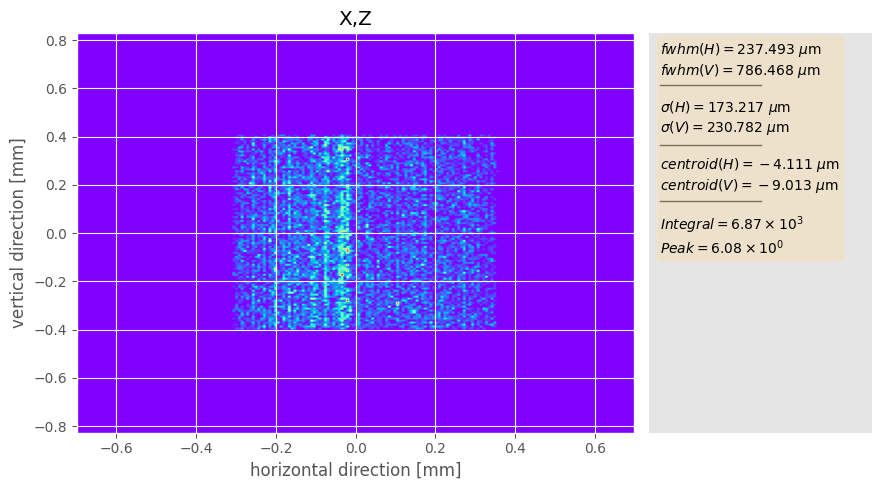

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.04396853647200966, 0.26011270687059035] 1644.6683556963026


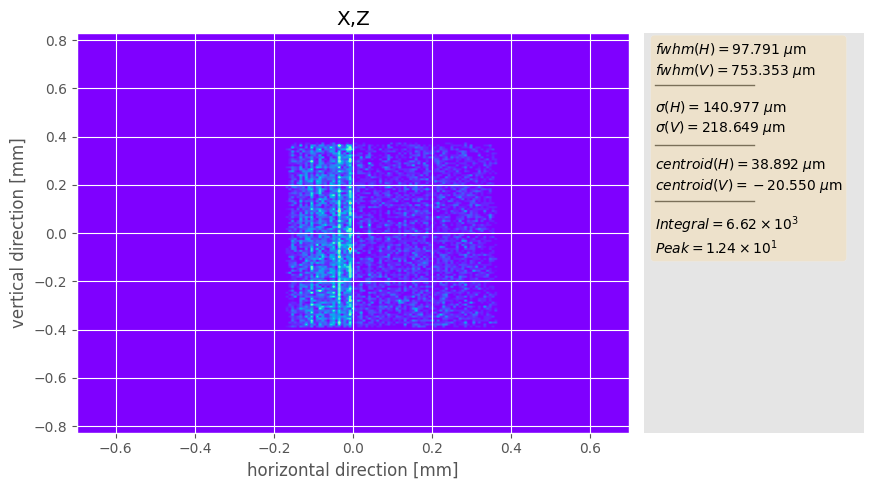

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.00876383529983516, 0.28880113775029304] 1756.7347679502066


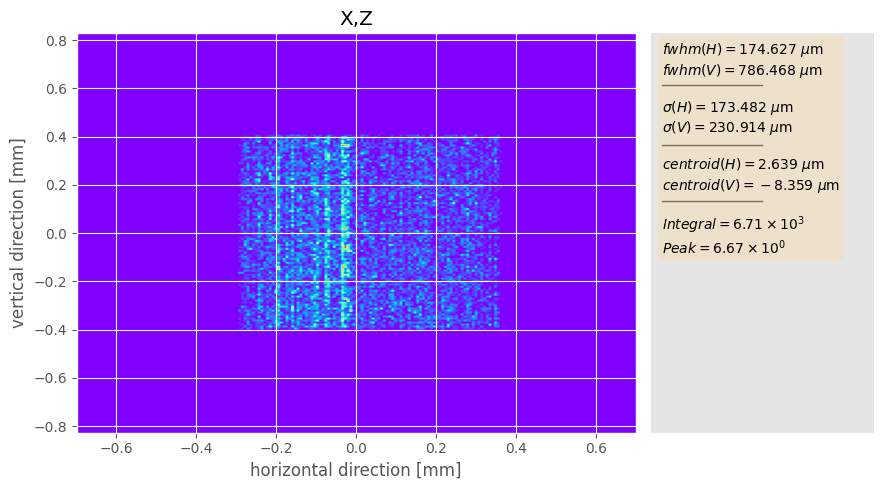

In [102]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [80]:
opt_trial.trials(100)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Appli

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:12:26,367] Trial 30 finished with values: [0.015381117216267884, 0.332253567320533] and parameters: {'hb_1': 1.0, 'hb_2': -31.0, 'hb_pitch': -0.01125, 'hb_trans': 19.9, 'vb_bender': 14.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 4.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:12:30,427] Trial 31 finished with values: [0.013228709472282675, 0.32320324976350745] and parameters: {'hb_1': 1.0, 'hb_2': -36.0, 'hb_pitch': -0.01125, 'hb_trans': 19.9, 'vb_bender': 20.0, 'vb_pitch': -0.01125, 'vb_trans': 1.6000000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of ini

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:12:53,165] Trial 32 finished with values: [0.03191543517655255, 0.3128960843460297] and parameters: {'hb_1': -1.0, 'hb_2': -40.0, 'hb_pitch': -0.0095, 'hb_trans': 19.9, 'vb_bender': 28.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 2.200000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:12:58,136] Trial 33 finished with values: [0.017329421573033313, 0.30300330273549947] and parameters: {'hb_1': -6.0, 'hb_2': -46.0, 'hb_pitch': -0.01125, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': 1.4000000000000021}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:13:21,869] Trial 34 finished with values: [0.016036771754229448, 0.296315444257112] and parameters: {'hb_1': -11.0, 'hb_2': -50.0, 'hb_pitch': -0.01475, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': 1.1000000000000014}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(
[I 2022-11-07 15:13:30,700] Trial 35 finished with values: [0.01214058260629628, 0.28944209343035693] and pa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the r

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:13:52,905] Trial 36 finished with values: [0.014369672102535267, 0.31019480499804836] and parameters: {'hb_1': -17.0, 'hb_2': -38.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 13.0, 'vb_bender': 21.0, 'vb_pitch': -0.0095, 'vb_trans': 1.7000000000000028}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:14:14,803] Trial 37 finished with values: [0.012778622405269943, 0.2767557477821952] and parameters: {'hb_1': -27.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -17.2}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:14:20,567] Trial 38 finished with values: [0.019878019116481235, 0.26946809816213496] and parameters: {'hb_1': -32.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -26.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:14:26,844] Trial 39 finished with values: [0.030623728346303936, 0.2717642934522932] and parameters: {'hb_1': -44.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -0.29999999999999716}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:14:34,911] Trial 40 finished with values: [0.03489291215332482, 0.2558727796402717] and parameters: {'hb_1': -49.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:14:57,825] Trial 41 finished with values: [0.034532531417558014, 0.25825493002148364] and parameters: {'hb_1': -50.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.01125, 'vb_trans': -22.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of i

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:16:11,974] Trial 44 finished with values: [0.0025613267709311423, 0.30153003145669754] and parameters: {'hb_1': -12.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 18.300000000000004, 'vb_bender': 23.0, 'vb_pitch': -0.01125, 'vb_trans': 1.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:16:18,516] Trial 45 finished with values: [0.032734405608857174, 0.25710901840427197] and parameters: {'hb_1': -50.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 15.5, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:16:38,520] Trial 46 finished with values: [0.005069995313983407, 0.29791927955178343] and parameters: {'hb_1': -13.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 14.200000000000003, 'vb_bender': 21.0, 'vb_pitch': -0.01125, 'vb_trans': -15.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:16:47,279] Trial 47 finished with values: [0.0014724838045120836, 0.3002113421550365] and parameters: {'hb_1': -14.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 22.0, 'vb_pitch': -0.01125, 'vb_trans': 0.8000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:17:10,390] Trial 48 finished with values: [0.0028591380485522497, 0.2972805613245798] and parameters: {'hb_1': -15.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 21.0, 'vb_pitch': -0.01125, 'vb_trans': -6.599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/opti

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the r

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:18:07,898] Trial 50 finished with values: [0.007250134949066389, 0.3081659080417367] and parameters: {'hb_1': -6.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 21.0, 'vb_pitch': -0.01125, 'vb_trans': 3.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:18:36,606] Trial 51 finished with values: [0.012167730098376146, 0.2992284972046524] and parameters: {'hb_1': -16.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.200000000000003, 'vb_bender': 23.0, 'vb_pitch': -0.013000000000000001, 'vb_trans': 3.5}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:328: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(
/Applications/Oasys1.3.app/Conte

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:19:11,972] Trial 53 finished with values: [0.0042258845654343504, 0.2981045053865507] and parameters: {'hb_1': -18.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.0, 'vb_bender': 22.0, 'vb_pitch': -0.01125, 'vb_trans': 2.3000000000000043}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:19:16,416] Trial 54 finished with values: [0.030640504687178976, 0.2604732948937758] and parameters: {'hb_1': -50.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 11.900000000000002, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -25.1}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  wa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:20:26,937] Trial 60 finished with values: [0.0066317705701915705, 0.2813913105269468] and parameters: {'hb_1': -38.0, 'hb_2': -50.0, 'hb_pitch': -0.0095, 'hb_trans': 18.5, 'vb_bender': 25.0, 'vb_pitch': -0.01125, 'vb_trans': 1.4000000000000021}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-30, 29.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-30, 29.9].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.


[I 2022-11-07 15:20:35,781] Trial 61 finished with values: [0.08534477074265355, 0.25530860795554444] and parameters: {'hb_1': -50.0, 'hb_2': -50.0, 'hb_pitch': -0.0007500000000000007, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.02, 'vb_trans': -30.0}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 1.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:668: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/A

In [81]:
opt_trial.study.best_trials

[FrozenTrial(number=40, values=[0.03489291215332482, 0.2558727796402717], datetime_start=datetime.datetime(2022, 11, 7, 15, 14, 26, 844979), datetime_complete=datetime.datetime(2022, 11, 7, 15, 14, 34, 911228), params={'hb_1': -49.0, 'hb_2': -50.0, 'hb_pitch': -0.013000000000000001, 'hb_trans': 19.9, 'vb_bender': 30.0, 'vb_pitch': -0.0095, 'vb_trans': -30.0}, distributions={'hb_1': FloatDistribution(high=50.0, log=False, low=-50.0, step=1.0), 'hb_2': FloatDistribution(high=50.0, log=False, low=-50.0, step=1.0), 'hb_pitch': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'hb_trans': FloatDistribution(high=19.9, log=False, low=-20.0, step=0.1), 'vb_bender': FloatDistribution(high=30.0, log=False, low=-30.0, step=1.0), 'vb_pitch': FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175), 'vb_trans': FloatDistribution(high=29.9, log=False, low=-30.0, step=0.1)}, user_attrs={'sum_intensity_constraint': 1, 'centroid_constraint': -1, 'sigma_constraint': -1, 'wsum

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_5518/3803381583.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


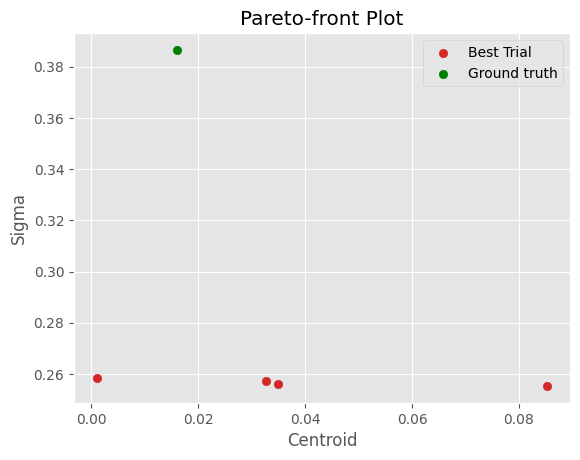

In [82]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [83]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-4.718546473117558
-4.777583682825381
-3.826338338293497
-8.303572655271788


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.03489291215332482, 0.2558727796402717] 1576.8883389340938
BeamParameterOutput(parameter_value=0.034883313950690636, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f8f83be19d0>, hist=<aps.ai.autoalignment.common.util.common.Histogram object at 0x7f8f83bc8e50>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7f8f83be1f10>)


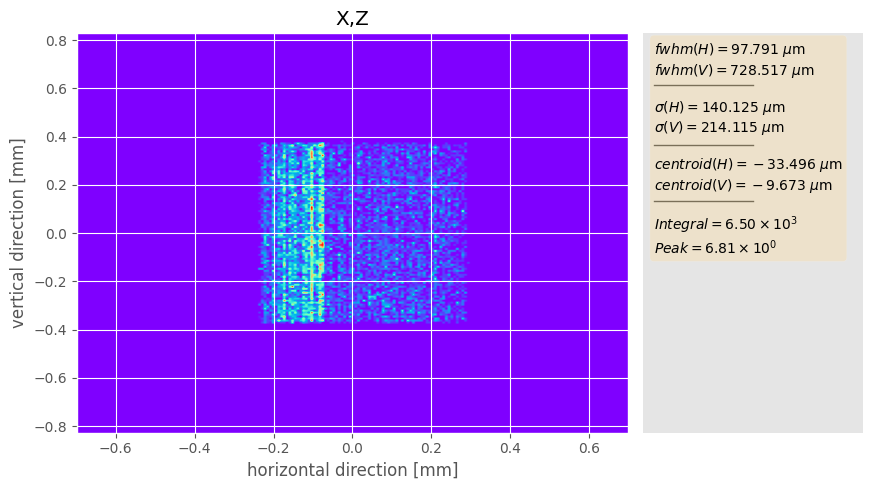

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_28-ID-53759/Downstream_HKB_bender_profile.dat written to disk.
[0.032734405608857174, 0.25710901840427197] 1574.598614491046
BeamParameterOutput(parameter_value=0.03272669023605714, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f8f97d01a60>, hist=<aps.ai.autoalignment.common.util.common.Histogram object at 0x7f8f83be1ca0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7f8f83be15b0>)


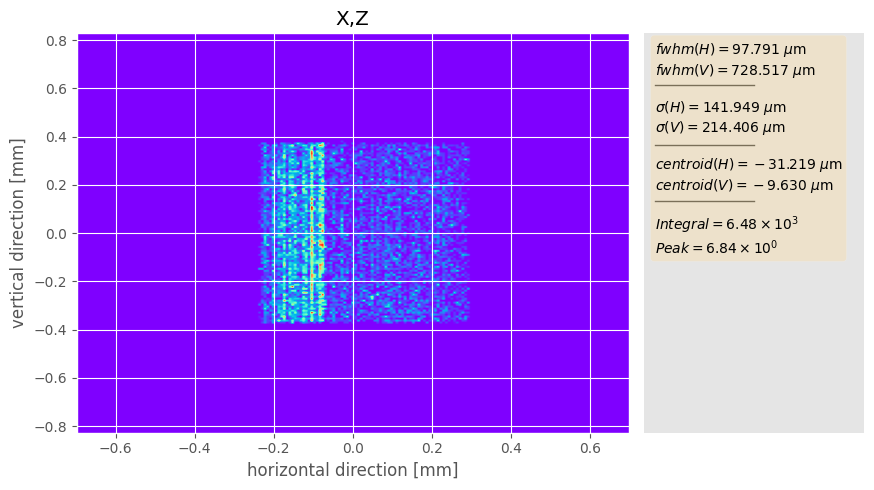

[0.08534477074265355, 0.25530860795554444] 1595.8595925181996
BeamParameterOutput(parameter_value=0.08536268671379546, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f8f97cfda30>, hist=<aps.ai.autoalignment.common.util.common.Histogram object at 0x7f8f79db5610>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7f8f97d01fd0>)


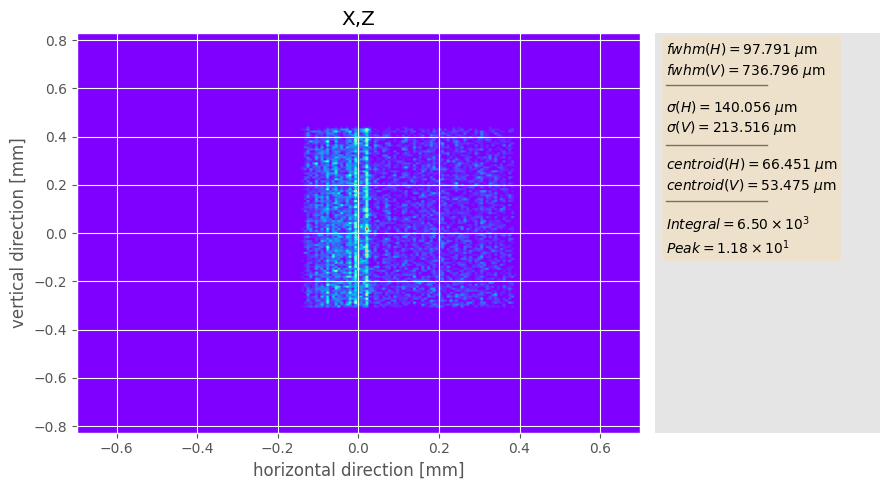

[0.000958398237153347, 0.25837959283146894] 1566.2424236719326
BeamParameterOutput(parameter_value=0.000949280345078979, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7f8f94c329a0>, hist=<aps.ai.autoalignment.common.util.common.Histogram object at 0x7f8f83c9dca0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7f8f82068970>)


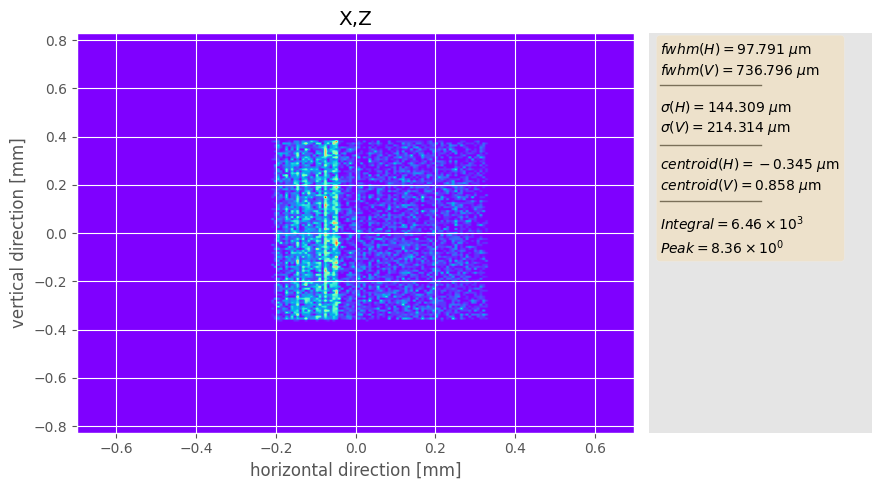

In [84]:
best_absolute_positions = []
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    pos_this = movers.get_absolute_positions(focusing_system, opt_trial.motor_types)
    best_absolute_positions.append(pos_this)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [129]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

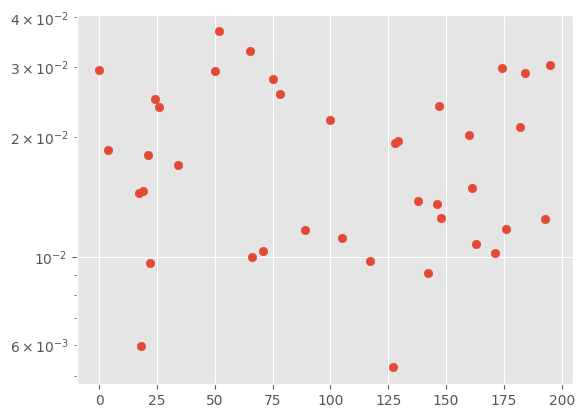

In [130]:
plt.scatter(tnums, centroids)
plt.yscale('log')

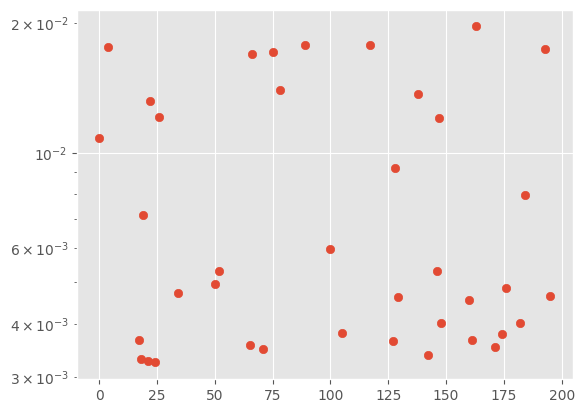

In [131]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

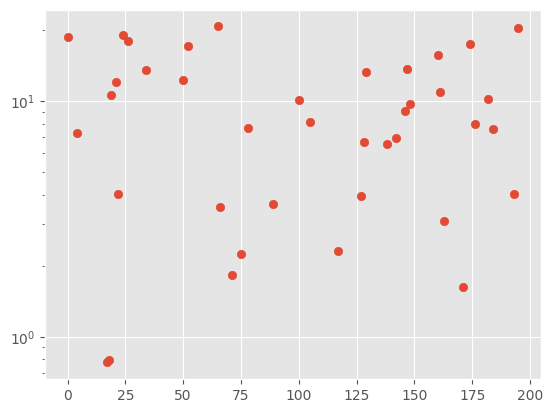

In [132]:
plt.scatter(tnums, wsums)
plt.yscale('log')

In [133]:
np.round(best_absolute_positions, 2)

array([[ 2.4863e+02,  1.6065e+02,  1.5413e+02,  2.2695e+02,  2.9600e+00,
         3.0100e+00, -6.6600e+00, -8.0100e+00],
       [ 2.4863e+02,  1.6065e+02,  1.5413e+02,  2.2695e+02,  2.9800e+00,
         2.9500e+00,  3.2700e+00,  4.4700e+00],
       [ 2.4863e+02,  1.6065e+02,  1.5413e+02,  2.2695e+02,  3.0100e+00,
         2.9500e+00, -4.4400e+00, -4.2300e+00],
       [ 2.0810e+02,  2.0484e+02,  1.4287e+02,  2.3596e+02,  3.0000e+00,
         2.9900e+00, -1.5000e-01,  4.7300e+00]])

In [134]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])

### Different starting structure + increased motor range

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

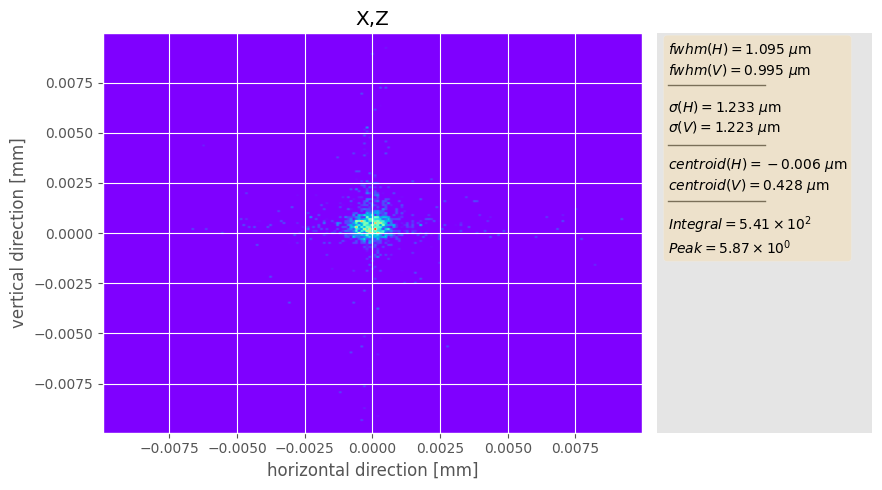

In [147]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [148]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.00041717203996423136, 0.002736531805781683)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

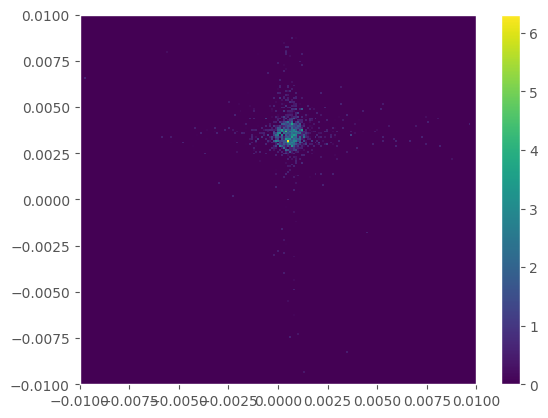

In [149]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [150]:
hist.data_2D.sum()

541.6701785268823

In [151]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
0.0036457370635303906 0.0027037408069067632


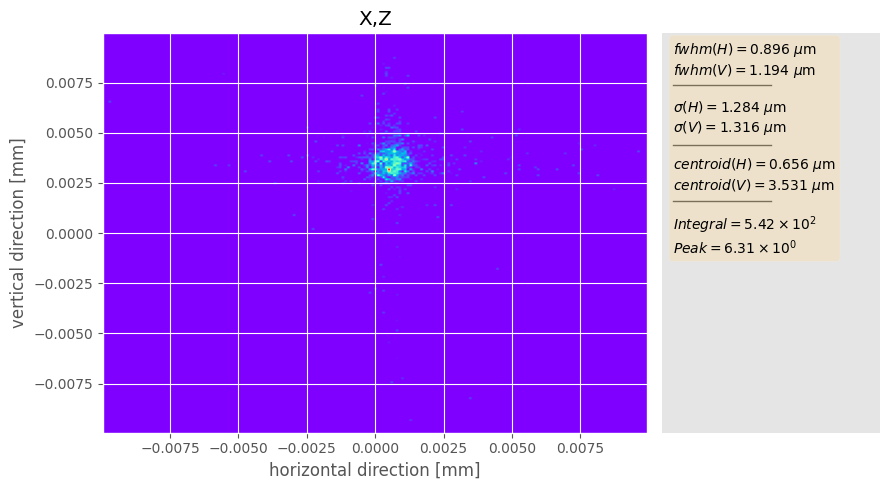

In [152]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [153]:
move_motors_ranges_2 = {k: [v[0] * 2, v[1] * 2] for k,v in move_motors_ranges.items()}

In [154]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.01, 0.01],
                            camera_yrange=[-0.01, 0.01],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

In [155]:
constraints = {"integral_intensity": 500, "centroid":5e-3, "sigma":5e-3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=False,#True,
    use_discrete_space=True,
    moo_thresholds={"centroid": 1e-3, "sigma": 2e-3},
    constraints=constraints,
)

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:300: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler(
[I 2022-10-17 22:08:12,901] A new study created in memory with name: no-name-f2bf8b40-d539-4082-be1d-e14b24fdb41d


In [156]:
opt_trial.trials(20, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:421: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
[I 2022-10-17 22:08:17,892] Trial 0 finished with values: [0.003591196890625

In [157]:
opt_trial.study.best_trials

[FrozenTrial(number=10, values=[0.00043202702979899284, 0.0017396415416890475], datetime_start=datetime.datetime(2022, 10, 17, 22, 8, 24, 466019), datetime_complete=datetime.datetime(2022, 10, 17, 22, 8, 26, 777924), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.4000000000000004, 'vkb_4': -0.7999999999999998}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'i

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


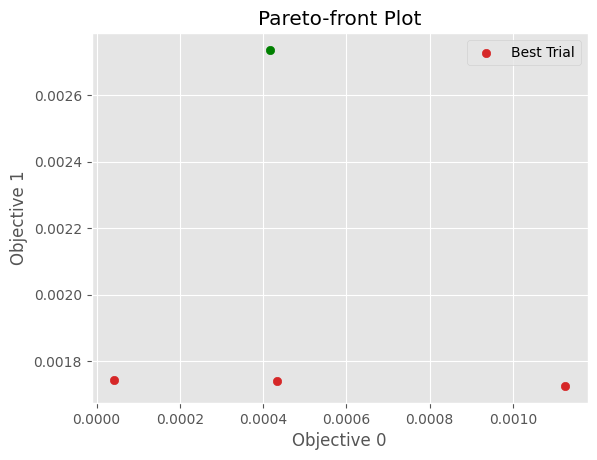

In [158]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [159]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-14.10109860020069 0.587965273989006
-13.151979122265928 0.7715940107357685
-16.4244690011505 0.5390793114962008


[0.00043202702979899284, 0.0017396415416890475] 0.587965273989006


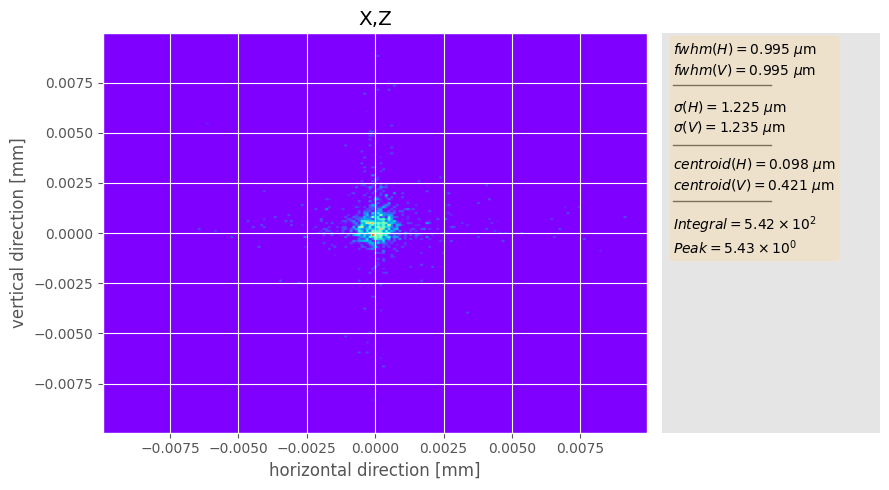

[0.001125139095771311, 0.0017256861974369257] 0.7715940107357685


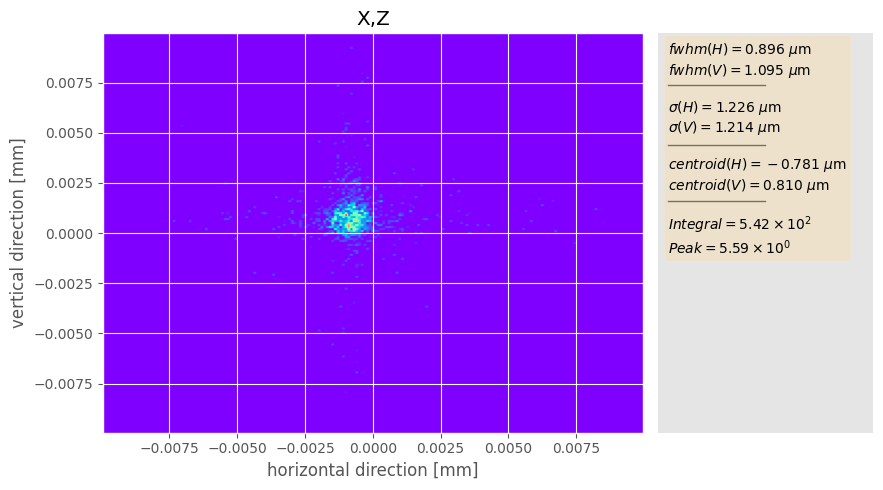

[4.222216804811069e-05, 0.0017434247806688843] 0.5390793114962008


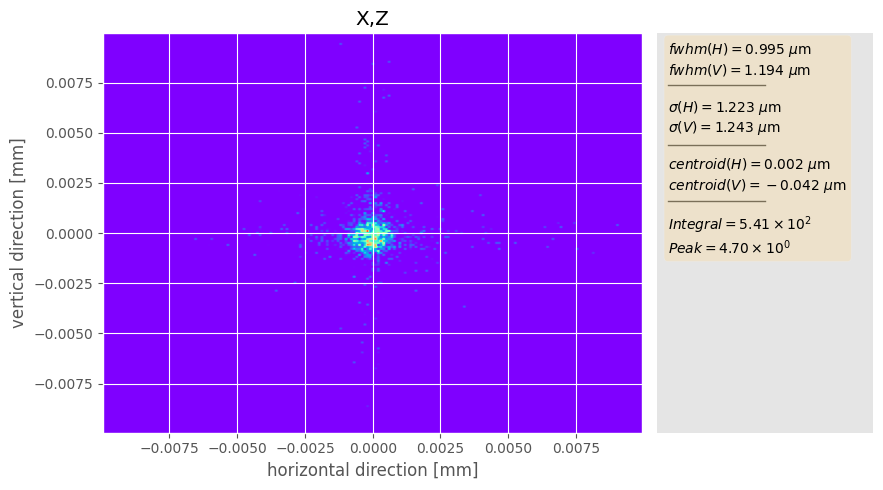

In [160]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [161]:
opt_trial.trials(20)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:11,743] Trial 20 finished with values: [0.0022052266649576803, 0.001820731224761131] and parameters: {'hkb_1': 1.1472000000000007, 'vkb_1': -0.7363999999999997, 'hkb_2': -0.8911999999999995, 'vkb_2': 1.2532000000000005, 'hkb_3': 0.00925, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.4000000000000004, 'vkb_4': -2.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:15,574] Trial 21 finished with values: [0.0023199456611681267, 0.001834959669352522] and parameters: {'hkb_1': -0.8895, 'vkb_1': -0.6688000000000001, 'hkb_2': 0.27890000000000015, 'vkb_2': -0.7953000000000001, 'hkb_3': 0.0022500000000000003, 'vkb_3': -0.0012499999999999994, 'hkb_4': 3.200000000000001, 'vkb_4': -1.6999999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:19,401] Trial 22 finished with values: [0.001314782738524927, 0.0018039766899420131] and parameters: {'hkb_1': 2.7762000000000002, 'vkb_1': 1.8639000000000001, 'hkb_2': 0.03910000000000036, 'vkb_2': -1.101, 'hkb_3': 0.0005000000000000004, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.9000000000000004, 'vkb_4': -0.5999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:23,661] Trial 23 finished with values: [0.0012643248070477555, 0.001812361439035037] and parameters: {'hkb_1': 2.5594, 'vkb_1': 2.0703000000000005, 'hkb_2': -1.9322999999999997, 'vkb_2': 1.8613, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00475, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.09999999999999964}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:27,075] Trial 24 finished with values: [0.0009400651361345877, 0.0017482039625744043] and parameters: {'hkb_1': -2.2483, 'vkb_1': 1.388, 'hkb_2': 0.6763000000000003, 'vkb_2': 3.4062, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00475, 'hkb_4': 1.5, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:30,638] Trial 25 finished with values: [0.000927326513387335, 0.001740619132490253] and parameters: {'hkb_1': 2.7730000000000006, 'vkb_1': 2.3422, 'hkb_2': 1.3005000000000004, 'vkb_2': 4.937800000000001, 'hkb_3': 0.00925, 'vkb_3': -0.00475, 'hkb_4': 1.8000000000000007, 'vkb_4': -0.8999999999999995}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:34,392] Trial 26 finished with values: [0.0018300757320972474, 0.0018220989545036379] and parameters: {'hkb_1': 0.2528000000000006, 'vkb_1': 4.4937000000000005, 'hkb_2': 2.4843, 'vkb_2': -0.18799999999999972, 'hkb_3': 0.00925, 'vkb_3': -0.003, 'hkb_4': 1.2000000000000002, 'vkb_4': -1.0999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:38,038] Trial 27 finished with values: [0.0007018879808766102, 0.0017670175401012708] and parameters: {'hkb_1': 4.4914000000000005, 'vkb_1': 2.9279, 'hkb_2': -0.19320000000000004, 'vkb_2': 3.714500000000001, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:41,501] Trial 28 finished with values: [0.0020939625120553083, 0.0018401436643029382] and parameters: {'hkb_1': -2.4772, 'vkb_1': 3.5062999999999995, 'hkb_2': 0.1034000000000006, 'vkb_2': 4.538600000000001, 'hkb_3': 0.004, 'vkb_3': -0.00825, 'hkb_4': 1.6000000000000005, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:45,052] Trial 29 finished with values: [0.00038844259897598515, 0.0017279508105304665] and parameters: {'hkb_1': 0.6790000000000003, 'vkb_1': 0.14310000000000045, 'hkb_2': -0.7965999999999998, 'vkb_2': 2.2817000000000007, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.7000000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:48,724] Trial 30 finished with values: [0.0014513598076376867, 0.001886775824610826] and parameters: {'hkb_1': 1.9097, 'vkb_1': 3.3642000000000003, 'hkb_2': 0.1463000000000001, 'vkb_2': 2.6503000000000005, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00825, 'hkb_4': 1.1000000000000005, 'vkb_4': -0.1999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:52,429] Trial 31 finished with values: [0.0007268710571396884, 0.0017520321022761567] and parameters: {'hkb_1': 2.8404000000000007, 'vkb_1': 2.2966000000000006, 'hkb_2': -0.2629999999999999, 'vkb_2': 1.2524000000000006, 'hkb_3': 0.00575, 'vkb_3': -0.006500000000000001, 'hkb_4': 2.6000000000000005, 'vkb_4': -0.1999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:55,994] Trial 32 finished with values: [0.0011392921130496249, 0.001778591086135265] and parameters: {'hkb_1': -2.9365, 'vkb_1': 0.18909999999999982, 'hkb_2': 2.6484000000000005, 'vkb_2': 2.9571000000000005, 'hkb_3': 0.00575, 'vkb_3': -0.003, 'hkb_4': 1.8000000000000007, 'vkb_4': -0.7999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:59,907] Trial 33 finished with values: [0.0012861534434538615, 0.001800911327061516] and parameters: {'hkb_1': -1.2386, 'vkb_1': 0.6276000000000002, 'hkb_2': 1.3567, 'vkb_2': 3.4945000000000004, 'hkb_3': 0.0022500000000000003, 'vkb_3': -0.006500000000000001, 'hkb_4': 2.3000000000000007, 'vkb_4': -0.7000000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:03,402] Trial 34 finished with values: [0.0009142041626542534, 0.001739723731946215] and parameters: {'hkb_1': 0.8382000000000005, 'vkb_1': 2.7092, 'hkb_2': 2.2637, 'vkb_2': 4.5908, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.003, 'hkb_4': 1.7000000000000002, 'vkb_4': -1.2999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:06,868] Trial 35 finished with values: [0.0008598148408121332, 0.0017710609843576597] and parameters: {'hkb_1': 3.2795000000000005, 'vkb_1': 3.236700000000001, 'hkb_2': 0.8233000000000006, 'vkb_2': 2.2228000000000003, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.006500000000000001, 'hkb_4': 3.0, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:10,660] Trial 36 finished with values: [0.0010906233080353882, 0.0017607614054138464] and parameters: {'hkb_1': 0.7509000000000006, 'vkb_1': 4.0692, 'hkb_2': 2.5474000000000006, 'vkb_2': 4.9452, 'hkb_3': 0.0005000000000000004, 'vkb_3': -0.003, 'hkb_4': 1.7000000000000002, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:14,496] Trial 37 finished with values: [0.0004245507466977374, 0.0017782936323595502] and parameters: {'hkb_1': -2.2603999999999997, 'vkb_1': 1.3959000000000001, 'hkb_2': 1.9503000000000004, 'vkb_2': 1.4780000000000006, 'hkb_3': -0.0012499999999999994, 'vkb_3': -0.003, 'hkb_4': 0.7000000000000002, 'vkb_4': -2.1999999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:17,954] Trial 38 finished with values: [0.0014205399415748003, 0.0018102235142417585] and parameters: {'hkb_1': 1.2283, 'vkb_1': 3.7634000000000007, 'hkb_2': 0.8696000000000002, 'vkb_2': 4.848600000000001, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.9000000000000004, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:21,288] Trial 39 finished with values: [0.0009370981482244066, 0.0017319567657995362] and parameters: {'hkb_1': 1.8671000000000006, 'vkb_1': 3.3221000000000007, 'hkb_2': 2.2189000000000005, 'vkb_2': 1.5054000000000007, 'hkb_3': 0.00575, 'vkb_3': -0.00475, 'hkb_4': 2.4000000000000004, 'vkb_4': -2.0}. 


In [162]:
opt_trial.study.best_trials

[FrozenTrial(number=17, values=[0.001125139095771311, 0.0017256861974369257], datetime_start=datetime.datetime(2022, 10, 17, 22, 8, 43, 828900), datetime_complete=datetime.datetime(2022, 10, 17, 22, 8, 46, 723714), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.00575, 'vkb_3': -0.003, 'hkb_4': 2.7, 'vkb_4': -1.1999999999999997}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'integral_intensity

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


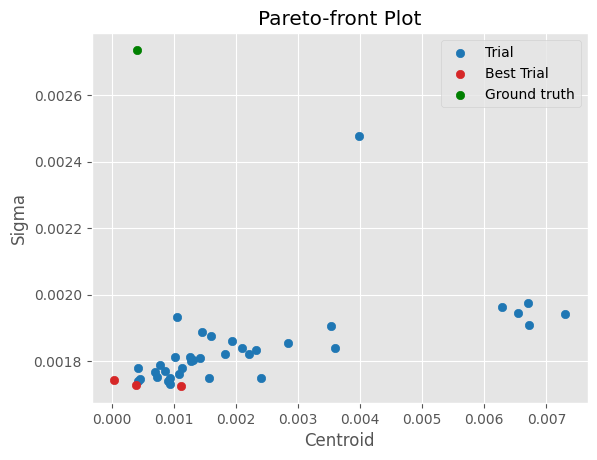

In [163]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [164]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.151979122265928
-16.4244690011505
-14.214184224589943


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

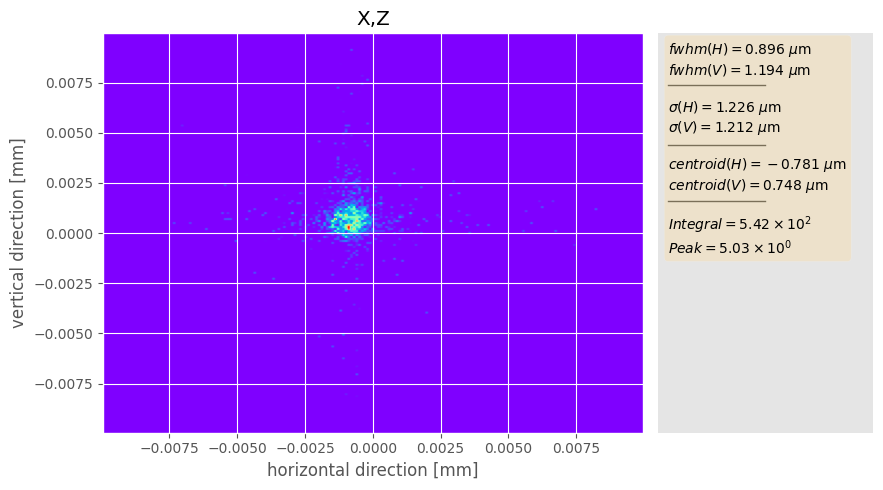

[4.222216804811069e-05, 0.0017434247806688843] 0.5390793114962008
BeamParameterOutput(parameter_value=9.816945689093482e-05, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7fe8ebefc790>, hist=<aps_ai.common.util.common.Histogram object at 0x7fe8789d99d0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7fe8882569a0>)


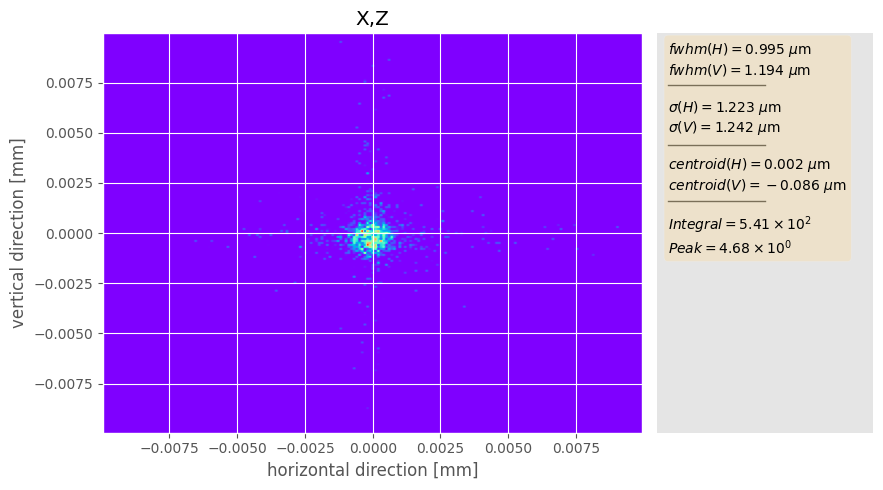

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

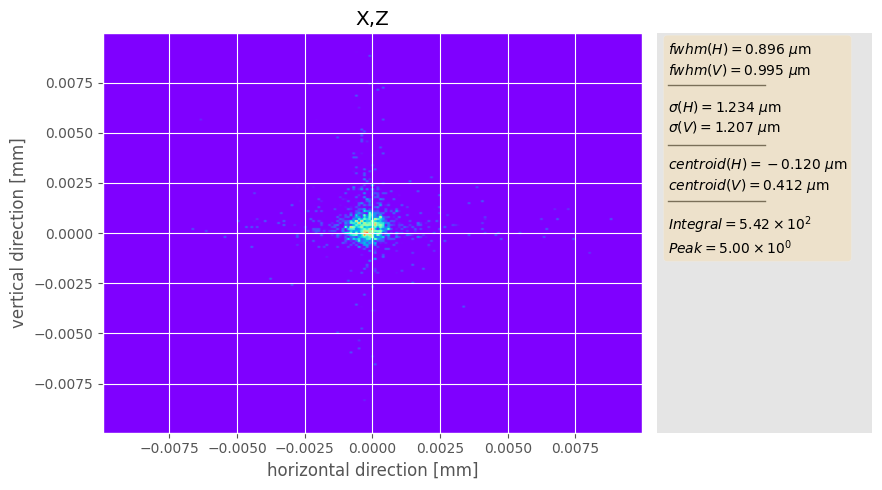

In [165]:
best_absolute_positions = []
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    pos_this = movers.get_absolute_positions(focusing_system, opt_trial.motor_types)
    best_absolute_positions.append(pos_this)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [166]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

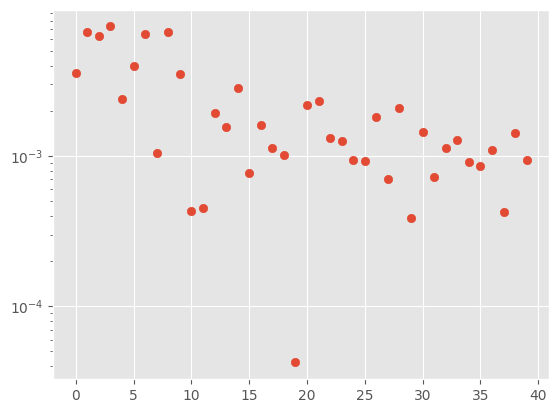

In [167]:
plt.scatter(tnums, centroids)
plt.yscale('log')

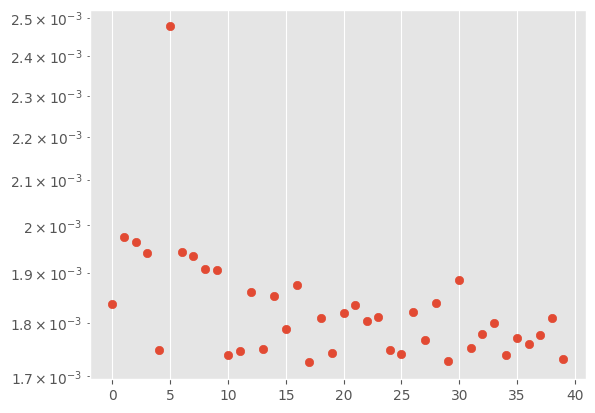

In [168]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

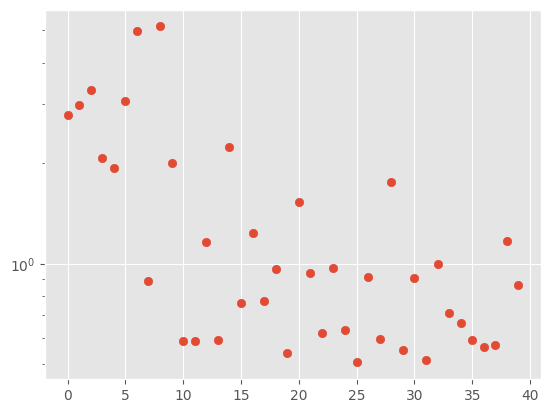

In [169]:
plt.scatter(tnums, wsums)
plt.yscale('log')

In [170]:
np.round(best_absolute_positions, 2)

array([[216.64, 143.  , 115.19, 227.16,   3.  ,   2.99,   0.81,   2.6 ],
       [216.64, 143.  , 115.19, 227.16,   3.  ,   2.99,  -0.39,   3.5 ],
       [217.32, 143.14, 114.39, 229.45,   3.  ,   2.99,  -0.29,   3.1 ]])

In [171]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])